SMILES : CCC(CC(=O)O)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)OCCCC(=O)OC(CC)CC(=O)OCCOC(=O)OCCCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OCCOC(=O)CCCOC(=O)OC(CC)CC(=O)OC(CC)CC(=O)O
Degree : 20
Sequence: ['A', 'B', 'A', 'D', 'B', 'A', 'A', 'D', 'B', 'A', 'D', 'A', 'A', 'A', 'A', 'D', 'A', 'A', 'A', 'A']

Descriptors:
MaxAbsEStateIndex             : 12.988422376339745
MaxEStateIndex                : 12.988422376339745
MinAbsEStateIndex             : 0.0061022159879697835
MinEStateIndex                : -1.143429429813548
qed                           : 0.03243181247473874
SPS                           : 13.700729927007298
MolWt                         : 1972.0910000000001
HeavyAtomMolWt                : 1828.954999999999
ExactMolWt                    : 1970.8772270639988
NumValenceElectrons           : 782
NumRadicalElectrons           : 0
MaxPartialCharge              : 0.5080517166770206
MinPartialCharge              : -0.481128499

[20:35:21] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 


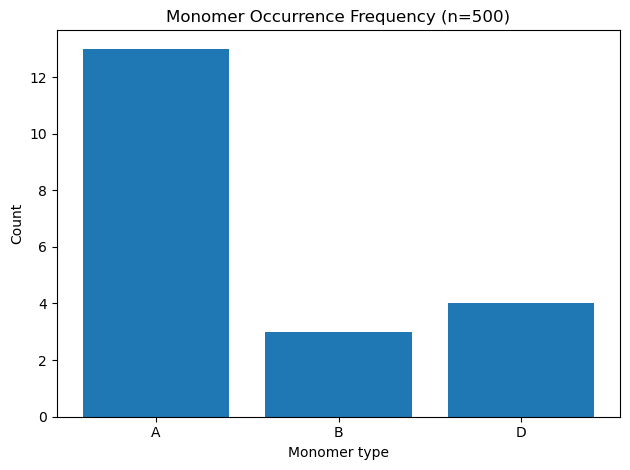

In [126]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import random, collections
import collections
from collections import Counter
import matplotlib.pyplot as plt


# 1. モノマー定義
monomers = {
    "A": {"smiles": "OC(CC)CC(=O)O",    "ends": ["OH", "COOH"]},
    "B": {"smiles": "OCCO",             "ends": ["OH", "OH"]},
    "C": {"smiles": "OC(=O)CCC(=O)O",   "ends": ["COOH", "COOH"]},
    "D": {"smiles": "OC(=O)CCCOC(=O)O", "ends": ["COOH", "COOH"]},
}
mole_ratio = {"A":0.5,"B":0.25,"C":0.01,"D":0.24}

# 2. 縮合反応
rxn = AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[OH:4][C:5]>>[C:1](=[O:2])[O:4][C:5]")

# 3. ユーティリティ
def w_choice(d):
    r = random.uniform(0, sum(d.values()))
    s = 0
    for k,w in d.items():
        s += w
        if r<=s:
            return k
    return k

def remove_one(counter, key):
    if counter[key] > 0:
        counter[key] -= 1
        if counter[key] == 0:
            del counter[key]

# 4. ポリマー生成
def build_polymer(target_units=20, seed=None):
    if seed is not None and seed >= 0:     # ★ seed=-1 ならランダム
        random.seed(seed)

    key = w_choice(mole_ratio)
    polymer   = Chem.MolFromSmiles(monomers[key]["smiles"])
    Chem.SanitizeMol(polymer)
    ends      = collections.Counter(monomers[key]["ends"])
    units     = 1
    sequence  = [key]                       # ★ シーケンス開始

    while units < target_units:
        # 末端にマッチする候補
        if   "OH"  in ends and "COOH" not in ends:
            pool = {m:w for m,w in mole_ratio.items() if "COOH" in monomers[m]["ends"]}
        elif "COOH" in ends and "OH"   not in ends:
            pool = {m:w for m,w in mole_ratio.items() if "OH"   in monomers[m]["ends"]}
        else:
            pool = mole_ratio

        if not pool:
            break

        next_key  = w_choice(pool)
        next_mol  = Chem.MolFromSmiles(monomers[next_key]["smiles"])
        Chem.SanitizeMol(next_mol)
        next_ends = collections.Counter(monomers[next_key]["ends"])

        choices = [
            (polymer, next_mol,  ends.copy(), next_ends.copy()),
            (next_mol, polymer,  next_ends.copy(), ends.copy())
        ]

        reacted = False
        for acid_mol, alc_mol, acid_ends, alc_ends in choices:
            if "COOH" in acid_ends and "OH" in alc_ends:
                prod = rxn.RunReactants((acid_mol, alc_mol))
                if prod:
                    polymer = prod[0][0]
                    Chem.SanitizeMol(polymer)
                    remove_one(acid_ends, "COOH")
                    remove_one(alc_ends,  "OH")
                    ends   = acid_ends + alc_ends
                    units += 1
                    sequence.append(next_key)   # ★ ユニット追加
                    reacted = True
                    break
        if not reacted:
            continue

    return Chem.MolToSmiles(polymer), units, sequence   # ★ 返り値拡張

# 5. 全記述子計算
def calc_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {"ERROR": "Invalid SMILES"}
    Chem.SanitizeMol(mol)
    return {name: func(mol) for name, func in Descriptors.descList}

# 6. 実行例
if __name__ == "__main__":
    smi, dp, seq = build_polymer(target_units=20, seed=-1)  # seed=-1 → ランダム
    print("SMILES :", smi)
    print("Degree :", dp)
    print("Sequence:", seq)                      # ★ シーケンス表示

    descs = calc_all_descriptors(smi)
    print("\nDescriptors:")
    for k, v in descs.items():
        print(f"{k:30}: {v}")

    freq = Counter(seq)

    # plot
    labels = list(freq.keys())
    values = [freq[l] for l in labels]

    plt.figure()
    plt.bar(labels, values)
    plt.title("Monomer Occurrence Frequency (n=500)")
    plt.xlabel("Monomer type")
    plt.ylabel("Count")
    plt.tight_layout()



[20:35:21] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[20:35:21] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[20:35:21] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 
[20:35:21] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 3 


CCC(CC(=O)NCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(=O)CCCOC(=O)OC(CC)CC(=O)OCCOC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OCCOC(=O)CCC(=O)OC(CC)CC(=O)OC(=O)CCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC(CC)CC(=O)OC(=O)CCC(=O)OCCOC(=O)CC(CC)OC(=O)CCC(=O)OC(=O)CCC(=O)OC(CC)CC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCC(=O)OC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCC(=O)OC(=O)CCCOC(=O)OC(=O)CCC(=O)OCCOC(=O)CCCOC(=O)OCCNC(=O)CC(CC)OC(=O)CCC(=O)OC(CC)CC(=O)OCCNC(=O)CCC(=O)OCCOC(=O)CC(CC)OC(=O)CCC(=O)OC(CC)CC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCCOC(=O)OC(=O)CCCOC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCC(=O)OCCOC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCC(=O)OC(CC)CC(=O)OCCNC(=O)CC(CC)OC(=O)CC(CC)OC(=O)CCC(=O)OCCOC(=O)CCC(=O)OC(

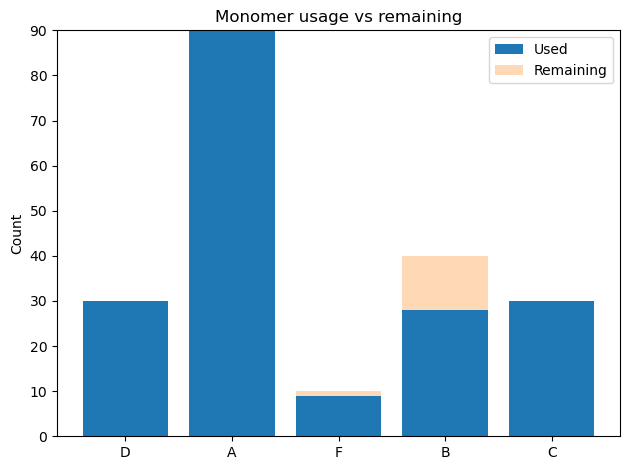

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from collections import Counter
import matplotlib.pyplot as plt

# ─── 1. モノマー定義 ───
monomers = {
    "A": {"smiles": "OC(CC)CC(=O)O", "ends": ["OH", "COOH"]},
    "B": {"smiles": "OCCO",          "ends": ["OH", "OH"]},
    "C": {"smiles": "OC(=O)CCC(=O)O","ends": ["COOH", "COOH"]},
    "D": {"smiles": "OC(=O)CCCOC(=O)O","ends": ["COOH","COOH"]},
    "E": {"smiles": "NCCN",          "ends": ["NH2", "NH2"]},
    "F": {"smiles": "NCCO",          "ends": ["NH2", "OH"]},
}
mole_ratio = {"A":0.4,"B":0.2,"C":0.15,"D":0.15,"E":0.05,"F":0.05}
TOTAL_UNITS = 200

# ─── 2. 反応 SMARTS（両方向） ───
reactions = [
    # エステル
    AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[OH:4][C:5]>>[C:1](=[O:2])[O:4][C:5]"),
    AllChem.ReactionFromSmarts("[OH:4][C:5].[C:1](=[O:2])[OH:3]>>[C:1](=[O:2])[O:4][C:5]"),
    # アミド（NH:4 でマッピング整合）
    AllChem.ReactionFromSmarts("[C:1](=[O:2])[OH:3].[NH2:4]>>[C:1](=[O:2])[NH:4]"),
    AllChem.ReactionFromSmarts("[NH2:4].[C:1](=[O:2])[OH:3]>>[C:1](=[O:2])[NH:4]")
]

# ─── 3. ユーティリティ ───
def init_inventory(ratio, total):
    inv, s = {}, 0
    for k,f in ratio.items():
        n = round(f*total); inv[k]=n; s+=n
    while s<total: k=max(ratio, key=ratio.get); inv[k]+=1; s+=1
    while s>total: k=max(inv, key=inv.get);    inv[k]-=1; s-=1
    return inv

def reacts(fg1, fg2):
    return (fg1=="COOH" and fg2 in ("OH","NH2")) or \
           (fg2=="COOH" and fg1 in ("OH","NH2"))

def weighted_choice(keys, inv):
    # 在庫数に比例して選択
    w_sum = sum(inv[k] for k in keys)
    r = random.uniform(0, w_sum)
    acc = 0
    for k in keys:
        acc += inv[k]
        if r <= acc:
            return k
    return keys[-1]

def remove_one(counter, fg):
    if counter[fg]>0:
        counter[fg]-=1
        if counter[fg]==0: del counter[fg]

# ─── 4. メイン ───
def build_polymer_feed(total_units=TOTAL_UNITS, seed=None,
                       max_retry_step=10, max_global_attempts=1000):
    if seed is not None: random.seed(seed)
    inv = init_inventory(mole_ratio, total_units)

    # 初期
    start = weighted_choice(list(inv.keys()), inv)
    inv[start]-=1
    polymer = Chem.MolFromSmiles(monomers[start]["smiles"])
    Chem.SanitizeMol(polymer)
    ends = Counter(monomers[start]["ends"])
    seq  = [start]

    global_fail = 0
    while sum(inv.values())>0 and global_fail < max_global_attempts:
        # 反応可能候補
        cands = [k for k,n in inv.items() if n and
                 any(reacts(f1,f2) for f1 in ends for f2 in monomers[k]["ends"])]
        if not cands: break

        success = False
        for _ in range(max_retry_step):
            nxt = weighted_choice(cands, inv)
            inv[nxt]-=1
            nxt_mol  = Chem.MolFromSmiles(monomers[nxt]["smiles"])
            Chem.SanitizeMol(nxt_mol)
            nxt_end  = Counter(monomers[nxt]["ends"])

            for acid,base,a_end,b_end in [
                (polymer,nxt_mol,ends.copy(),nxt_end.copy()),
                (nxt_mol,polymer,nxt_end.copy(),ends.copy())
            ]:
                for rxn in reactions:
                    prod = rxn.RunReactants((acid,base))
                    if prod:
                        polymer = prod[0][0]; Chem.SanitizeMol(polymer)
                        remove_one(a_end,"COOH")
                        # どちらの官能基が消えたかチェック
                        if "OH" in b_end:  remove_one(b_end,"OH")
                        elif "NH2" in b_end: remove_one(b_end,"NH2")
                        ends = a_end + b_end
                        seq.append(nxt)
                        success=True; break
                if success: break
            if success: break
            # 失敗→在庫戻し
            inv[nxt]+=1
        if success:
            global_fail = 0
        else:
            global_fail += 1  # 全候補失敗をカウント

    used = Counter(seq)
    return Chem.MolToSmiles(polymer), len(seq), used, inv

# ─── 5. 実行 ───
if __name__ == "__main__":
    smi, dp, used, remain = build_polymer_feed(seed=None)
    print(smi)
    print("DP :", dp, "\nUsed :", dict(used), "\nRemain:", dict(remain))

    # 可視化
    plt.bar(used.keys(), used.values(), label="Used")
    plt.bar(remain.keys(), remain.values(),
            bottom=[used.get(k,0) for k in remain],
            alpha=0.3, label="Remaining")
    plt.legend(); plt.ylabel("Count")
    plt.title("Monomer usage vs remaining")
    plt.tight_layout(); plt.show()


In [1]:
import itertools, pandas as pd, matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from ase import Atoms
from ase.optimize import BFGS
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# ---------- モノマー ----------
monomers = {
    "A": {"smiles": "OC(CC)CC(=O)O",  "ends": ["OH","COOH"]},
    "B": {"smiles": "OCCO",           "ends": ["OH","OH"]},
    "C": {"smiles": "OC(=O)CCC(=O)O", "ends": ["COOH","COOH"]},
    "D": {"smiles": "OC(=O)CCCOC(=O)O","ends":["COOH","COOH"]},
    "E": {"smiles": "NCCN",           "ends": ["NH2","NH2"]},
    "F": {"smiles": "NCCO",           "ends": ["NH2","OH"]},
}

# ---------- 反応 SMARTS 修正 ----------
rxn_smarts = {
    "ester" : "[C:1](=[O:2])-[OH:3].[O:4]-[*:5]>>[C:1](=[O:2])-[O:4]-[*:5].[O:3]",
    "amide" : "[C:1](=[O:2])-[OH:3].[N:4]-[*:5]>>[C:1](=[O:2])-[N:4]-[*:5].[O:3]",
}
reactions = {k: AllChem.ReactionFromSmarts(s) for k,s in rxn_smarts.items()}

# ---------- UMA Calculator ----------
predictor = pretrained_mlip.get_predict_unit("uma-s-1", device="cuda")  # "cpu" 可
def make_calc():                      # 画像ごとに独立した calc
    return FAIRChemCalculator(predictor, task_name="omol")

# ---------- RDKit→ASE & 最適化 ----------
def rdkit_to_ase(mol: Chem.Mol) -> Atoms:
    conf = mol.GetConformer()
    syms = [a.GetSymbol() for a in mol.GetAtoms()]
    pos  = conf.GetPositions()
    return Atoms(symbols=syms, positions=pos)

def prepare_rdkit(smiles):
    """SMILESから分子を準備（サニタイズ、水素追加、3D構造生成）"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    
    # 水素を追加してサニタイズ
    mol = Chem.AddHs(mol)
    Chem.SanitizeMol(mol)
    
    # 3D構造生成と最適化
    AllChem.EmbedMolecule(mol, randomSeed=17)
    result = AllChem.MMFFOptimizeMolecule(mol)
    if result != 0:
        print(f"Warning: MMFF optimization failed with status {result}")
    return mol

def single_energy(mol_rdkit):
    ase_mol = rdkit_to_ase(mol_rdkit)
    ase_mol.calc = make_calc()
    BFGS(ase_mol, logfile=None).run(fmax=0.02, steps=50)
    return ase_mol.get_potential_energy()

# ---------- 水分子の事前準備 ----------
water = prepare_rdkit("O")
E_water = single_energy(water)

# ---------- メインループ ----------
records = []
successful_reactions = 0

for acid_k, nuc_k in itertools.product(monomers, monomers):
    if acid_k == nuc_k:
        continue
        
    acid = monomers[acid_k]
    nuc = monomers[nuc_k]
    
    # 反応条件チェック
    if "COOH" not in acid["ends"]: 
        continue
    if not ("OH" in nuc["ends"] or "NH2" in nuc["ends"]): 
        continue

    # 反応タイプ決定
    rtype = "ester" if "OH" in nuc["ends"] else "amide"
    rxn = reactions[rtype]
    
    # モノマー分子の準備
    try:
        mol_acid = prepare_rdkit(acid["smiles"])
        mol_nuc = prepare_rdkit(nuc["smiles"])
    except Exception as e:
        print(f"Preparation failed: {acid_k} or {nuc_k} - {str(e)}")
        continue

    # 反応実行
    try:
        products = rxn.RunReactants((mol_acid, mol_nuc))
        print(products)
        if not products:
            print(f"No products formed: {acid_k} + {nuc_k}")
            continue
            
        # 主生成物を取得（水分子は除く）
        main_product = None
        for product_set in products:
            for prod in product_set:
                # 水分子(酸素原子1つ)はスキップ
                if prod.GetNumAtoms() > 1:
                    main_product = prod
                    break
            if main_product: break
            
        if not main_product:
            print(f"No main product found: {acid_k} + {nuc_k}")
            continue
            
        # 生成物の準備
        Chem.SanitizeMol(main_product)
        main_product = prepare_rdkit(Chem.MolToSmiles(main_product))
        
    except Exception as e:
        print(f"Reaction failed: {acid_k} + {nuc_k} - {str(e)}")
        continue

    # エネルギー計算
    try:
        E_react = single_energy(mol_acid) + single_energy(mol_nuc)
        E_prod = single_energy(main_product) + E_water
        dE = E_prod - E_react
        
        records.append({
            "Acid": acid_k, 
            "Nucleophile": nuc_k,
            "Type": rtype, 
            "dE_eV": dE
        })
        successful_reactions += 1
        print(f"Success: {acid_k} + {nuc_k} -> ΔE = {dE:.3f} eV")
        
    except Exception as e:
        print(f"Energy calculation failed: {acid_k} + {nuc_k} - {str(e)}")

# ---------- 結果処理 ----------
if successful_reactions == 0:
    print("No successful reactions recorded. Exiting.")
    exit()

df = pd.DataFrame(records)
print("\nReaction Energies:")
print(df)

# ピボットテーブル作成
try:
    pivot = df.pivot(index="Acid", columns="Nucleophile", values="dE_eV")
    print("\nPivot Table:")
    print(pivot)
    
    # プロット
    pivot.fillna(0, inplace=True)
    ax = pivot.plot(kind="bar", figsize=(10,5))
    ax.set_ylabel("Reaction Energy ΔE (eV)")
    ax.set_title("UMA-S Estimated Reaction Energies")
    plt.tight_layout()
    plt.savefig("reaction_energies.png")
    plt.show()
    
except Exception as e:
    print(f"Error in creating pivot table: {str(e)}")
    print("Raw data:")
    print(df)

/home/suehara/miniconda3/envs/torch89/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:Setting random seed to 41


((<rdkit.Chem.rdchem.Mol object at 0x7f7166348820>, <rdkit.Chem.rdchem.Mol object at 0x7f7166348900>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166348a50>, <rdkit.Chem.rdchem.Mol object at 0x7f7166348ac0>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166348b30>, <rdkit.Chem.rdchem.Mol object at 0x7f7166348ba0>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166348c10>, <rdkit.Chem.rdchem.Mol object at 0x7f7166348c80>))
Reaction failed: A + B - Explicit valence for atom # 2 O, 3, is greater than permitted
((<rdkit.Chem.rdchem.Mol object at 0x7f7166348970>, <rdkit.Chem.rdchem.Mol object at 0x7f71663489e0>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166348eb0>, <rdkit.Chem.rdchem.Mol object at 0x7f7166348f20>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166348f90>, <rdkit.Chem.rdchem.Mol object at 0x7f7166349000>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166349070>, <rdkit.Chem.rdchem.Mol object at 0x7f71663490e0>), (<rdkit.Chem.rdchem.Mol object at 0x7f7166349150>, <rdkit.Chem.rdchem.Mol object at 0x7f7166349

[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
[21:16:09] Explicit valence for atom # 2 N, 4, is greater than permitted
[21:16:09] Explicit valence for atom # 2 O, 3, is greater than permitted
